<a href="https://colab.research.google.com/github/regiiis/pv_error_classification/blob/main/pv_error_classifcation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DLV Group Project - **Semantic Segmentation**

## Set up

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [54]:
# General imports
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import savetxt
from numpy import genfromtxt
import os, datetime
import sys
import math
import random

# Import graph plotting lib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Imoprt tensorflow and set to eager execution
import tensorflow as tf
tf.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)

# Shortcuts to keras
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.utils import array_to_img
from IPython.display import Image

# Performance tools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

from PIL import Image
from PIL import Image as im
from skimage.transform import resize

In [3]:
# Import drive and allow access
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Unzip data
!unzip "/content/drive/My Drive/Colab Notebooks/data/2020-02-14_InfraredSolarModules.zip"

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: InfraredSolarModules/images/2121.jpg  
  inflating: InfraredSolarModules/images/11778.jpg  
  inflating: InfraredSolarModules/images/5896.jpg  
  inflating: InfraredSolarModules/images/4550.jpg  
  inflating: InfraredSolarModules/images/19324.jpg  
  inflating: InfraredSolarModules/images/16017.jpg  
  inflating: InfraredSolarModules/images/10472.jpg  
  inflating: InfraredSolarModules/images/2135.jpg  
  inflating: InfraredSolarModules/images/4.jpg  
  inflating: InfraredSolarModules/images/5882.jpg  
  inflating: InfraredSolarModules/images/19330.jpg  
  inflating: InfraredSolarModules/images/4544.jpg  
  inflating: InfraredSolarModules/images/16003.jpg  
  inflating: InfraredSolarModules/images/12265.jpg  
  inflating: InfraredSolarModules/images/9060.jpg  
  inflating: InfraredSolarModules/images/14614.jpg  
  inflating: InfraredSolarModules/images/6353.jpg  
  inflating: InfraredSolarModules/images/970

In [5]:
# Load data into df
df = pd.read_json("/content/InfraredSolarModules/module_metadata.json",orient="index")
df['image_name'] = df['image_filepath'].str[7:]
df = df.sort_index()
df

,image_filepath,anomaly_class,image_name
0,images/0.jpg,Offline-Module,0.jpg
1,images/1.jpg,Offline-Module,1.jpg
2,images/2.jpg,Offline-Module,2.jpg
3,images/3.jpg,Offline-Module,3.jpg
4,images/4.jpg,Offline-Module,4.jpg
...,...,...,...
19995,images/19995.jpg,No-Anomaly,19995.jpg
19996,images/19996.jpg,No-Anomaly,19996.jpg
19997,images/19997.jpg,No-Anomaly,19997.jpg
19998,images/19998.jpg,No-Anomaly,19998.jpg


## Explore Data

In [9]:
# Display all categories
categories = df["anomaly_class"].unique()
list(categories)

['Offline-Module',
 'Diode-Multi',
 'Diode',
 'Shadowing',
 'Cell-Multi',
 'Cell',
 'Hot-Spot',
 'Cracking',
 'Hot-Spot-Multi',
 'Soiling',
 'Vegetation',
 'No-Anomaly']

In [85]:
# Select and display for each categories one example
df.groupby('anomaly_class').head(1)

img1 = mpimg.imread('/content/InfraredSolarModules/images/13357.jpg') #No-Anomaly
img2 = mpimg.imread('/content/InfraredSolarModules/images/5988.jpg')  #Cell
img3 = mpimg.imread('/content/InfraredSolarModules/images/6796.jpg')  #Hot-Spot
img4 = mpimg.imread('/content/InfraredSolarModules/images/270.jpg')  #Offline-Module
img5 = mpimg.imread('/content/InfraredSolarModules/images/9528.jpg') #Vegetation
img6 = mpimg.imread('/content/InfraredSolarModules/images/2143.jpg')  #Diode
img7 = mpimg.imread('/content/InfraredSolarModules/images/3519.jpg')  #Shadowing
img8 = mpimg.imread('/content/InfraredSolarModules/images/7188.jpg')  #Cracking
img9 = mpimg.imread('/content/InfraredSolarModules/images/876.jpg') #Diode-Multi
img10 = mpimg.imread('/content/InfraredSolarModules/images/8019.jpg')  #Hot-Spot-Multi
img11 = mpimg.imread('/content/InfraredSolarModules/images/4592.jpg')  #Cell-Multi
img12 = mpimg.imread('/content/InfraredSolarModules/images/8291.jpg')  #Soiling

list_img = []
for i in range(12):
  list_img.append(f"img{i+1}")

#fig, axarr = plt.subplots(4,3,figsize=(10,18),dpi=150)

print(img12)



[[ 65  66  65  64  70  75  73  70  72  75  75  72  72  75  77  77  77  76
   76  75  73  74  71  63]
 [ 99 102 101 102 106 108 106 105 107 109 111 113 114 116 119 120 116 113
  112 111 108 106 101  91]
 [121 123 125 126 129 129 128 129 129 130 134 140 143 143 142 143 141 137
  135 132 128 125 117 105]
 [127 128 130 133 136 136 136 139 141 144 153 165 172 171 162 155 148 142
  139 137 134 130 120 108]
 [131 131 132 135 139 140 141 145 147 157 173 191 204 202 185 167 153 146
  143 141 137 133 124 112]
 [133 133 133 135 139 141 142 145 149 164 185 204 217 215 194 171 155 148
  144 142 138 133 124 113]
 [134 136 137 138 141 142 143 145 156 170 188 201 209 207 189 170 154 148
  145 144 139 134 125 115]
 [136 140 141 142 144 145 145 147 153 164 176 183 187 185 173 160 153 147
  145 145 140 135 127 118]
 [139 141 144 145 146 146 147 148 149 151 155 161 165 163 157 151 148 147
  146 145 141 138 131 124]
 [139 141 143 144 144 144 145 146 147 147 147 149 151 151 149 147 147 146
  146 146 144 141

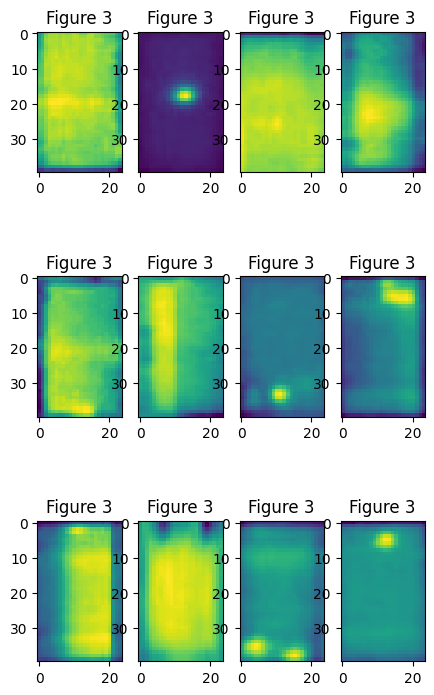

In [100]:

fig = plt.figure(figsize=(5, 9))
columns = 4
rows = 3
for i in range(1, columns*rows +1):
    img = f"img{i}"
    img = str("img")+str(i)
    fig.add_subplot(rows, columns, i)
    plt.imshow(globals()[img])
    plt.title("Figure 3")
plt.show()